# Adding an agent

In this section, we will add a new agent called `A2`. This agent will be slightly different to the other agents in the ```default``` example, in that it will make investments based upon a mixture of [levelised cost of electricity (LCOE)](https://en.wikipedia.org/wiki/Levelized_cost_of_energy) and [equivalent annual cost (EAC)](https://en.wikipedia.org/wiki/Equivalent_annual_cost). These two objectives will be combined by calculating a weighted sum of the two when comparing potential investment options. We will give the LCOE a relative weight value of 1 and the EAC a relative weight value  of 0.25.

We will continue to use the files from the previous tutorial where we added `solarPV` and created a new scenario. 

To achieve this, first, we must modify the ```Agents.csv``` file in the directory:

    {muse_install_location}/src/muse/data/example/default/technodata/Agents.csv

To do this, we will add two new rows to the file. To simplify the process, we copy the data from the first two rows of agent `A1`, changing only the rows: `AgentShare` `Name`, `Objective1`, `Objective2`, `ObjData1`, `ObjData2`, `DecisionMethod` and `Quantity`. The values we changed can be seen below. Notice how we edit the `AgentShare` column. This variable allows us to split the existing capacity between the two different agents. We will also need to edit the technodata file to define these new AgentShares.

Also notice that we amend the `Quantity` column. The reason for this is that we want to specify that Agent A1 makes up 50% of the population, and A2 makes up the remaining 50% of the population.

Again, we only show some of the rows due to space constraints, however see [here INSERT LINK HERE](broken-link) for the full file.

|AgentShare|Name|RegionName|Objective1|Objective2|Objective3|ObjData1|ObjData2|…|DecisionMethod|Quantity|…|Type|
|-|-|-|-|-|-|-|-|-|-|-|-|-|
|Agent1|A1|R1|LCOE|||1||…|singleObj|0.5|…|New|
|Agent2|A1|R1|LCOE|||1||…|singleObj|0.5|…|Retrofit|
|**Agent3**|**A2**|**R1**|**LCOE**|**EAC**||**1**|**0.25**|**…**|**weighted_sum**|0.5|**…**|**New**|
|**Agent4**|**A2**|**R1**|**LCOE**|**EAC**||**1**|**0.25**|**…**|**weighted_sum**|0.5|**…**|**Retrofit**|



We then edit the `technodata` file to split the existing capacity between the two agents by the proportions we like. As we now have two agents which take up 50% of the population each, we will split the existing capacity by 50% for each of the agents. Notice that we only require the columns `Agent2` and `Agent4` to define the retrofit agents.

The new technodata file will look like the following:

|ProcessName|RegionName|Time|Level|cap_par|cap_exp|…|Fuel|EndUse|Agent2|Agent4|
|-|-|-|-|-|-|-|-|-|-|-|
|Unit|-|Year|-|MUS$2010/PJ_a|-|…|-|-|Retrofit|**Retrofit**|
|gasCCGT|R1|2020|fixed|23.78234399|1|…|gas|electricity|**0.5**|**0.5**|
|windturbine|R1|2020|fixed|36.30771182|1|…|wind|electricity|**0.5**|**0.5**|
|solarPV|R1|2020|fixed|30|1|...|solar|electricity|**0.5**|**0.5**|



We will now save this file and run the new simulation model using the following command in Anaconda prompt:

    python -m muse settings.toml

Again, we use seaborn and pandas to analyse the data in the ```Results``` folder.

In [1]:
import pandas as pd
import seaborn as sns

In [2]:
mca_capacity = pd.read_csv("../tutorial-code/2-add-agent/1-multiple-objective/Results/MCACapacity.csv")
power_sector = mca_capacity[mca_capacity.sector=="power"]
power_sector.head()

,technology,region,agent,type,sector,capacity,year
2,gasCCGT,R1,A1,retrofit,power,1.0000,2020
3,gasCCGT,R1,A2,retrofit,power,1.0000,2020
10,gasCCGT,R1,A1,retrofit,power,1.0000,2025
11,windturbine,R1,A1,retrofit,power,8.4048,2025
12,gasCCGT,R1,A2,retrofit,power,1.0000,2025


This time we can see that there is data for the new agent, `A2`. Next, we will visualise the investments made by each of the agents using seaborn's facetgrid command.

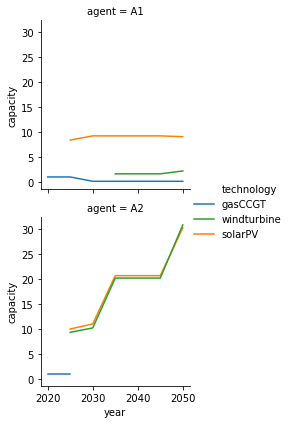

In [3]:
g=sns.FacetGrid(power_sector, row='agent')
g.map(sns.lineplot, "year", "capacity", "technology")
g.add_legend()

In this scenario we can see two divergent strategies. Agent `A2` invests heavily in `solarPV` and `windturbine`, and less so in `gasCCGT`. Whereas Agent `A1`  invests primarily in `solarPV`. 

From this small scenario, the difference between investment strategies between agents is evident. This is one of the key benefits of agent-based models when compared to optimisation based models.

Next, we will see what occurs if the agents invest based upon the same investment strategy, with both investing using LCOE. This requires us to edit the ```Agents.csv``` file once more, to look like the following:

|AgentShare|Name|AgentNumber|RegionName|Objective1|Objective2|Objective3|ObjData1|ObjData2|…|DecisionMethod|…|Type|
|-|-|-|-|-|-|-|-|-|-|-|-|-|
|Agent1|A1|1|R1|LCOE|||1||…|singleObj|…|New|
|Agent2|A1|2|R1|LCOE|||1||…|singleObj|…|Retrofit|
|Agent1|A2|1|R1|**LCOE**|||**1**||…|**singleObj**|…|New|
|Agent2|A2|2|R1|**LCOE**|||**1**||…|**singleObj**|…|Retrofit|

Again, this requires the re-running of the simulation, and to visualise the results like before:

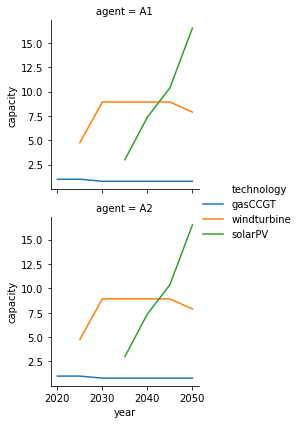

In [4]:
mca_capacity = pd.read_csv("../tutorial-code/2-add-agent/2-single-objective/Results/MCACapacity.csv")
power_sector = mca_capacity[mca_capacity.sector=="power"]
g=sns.FacetGrid(power_sector, row='agent')
g.map(sns.lineplot, "year", "capacity", "technology")
g.add_legend()

In this new scenario, with both agents running the same objective, very similar results between agents can be seen. There is a low uptake in `gasCCGT`, and competition between `solarPV` and `windturbine`, especially in the year 2040 where a change in the price of `solarPV` was set in the previous tutorial. 

As the two agents make the same decisions, we see the same scenario develop for both agents, unlike in the previous scenario.

Have a play around with the files to see if you can come up with different scenarios!

## Next steps 

In the next section we will show you how to add a new region. We will maintain the two agents in this next section, and all the work done in the previous tutorials.